In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import efficientnet.keras as efn

# model = efn.EfficientNetB6(weights='imagenet')
base_model = efn.EfficientNetB4(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
flatten_1 (Flatten)          (None, 87808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 175618    
Total params: 17,849,434
Trainable params: 175,618
Non-trainable params: 17,673,816
_________________________________________________________________


In [3]:
import pandas as pd

df = pd.read_csv('input/two_class_pap_acne.csv')
df['file_name']=df['image_id']+'.jpg'
df=df[['file_name','dx','lesion_id']]
#df.head()

from sklearn.model_selection import train_test_split
label_dataframe=df.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(df, label_dataframe, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)

(9, 2)
(33, 2)
(5, 2)


In [4]:
train=pd.concat([X_train,y_train],axis=1)
train.head()
val=pd.concat([X_val,y_val],axis=1)
val.head()
test=pd.concat([X_test,y_test],axis=1)
test.head()

,file_name,lesion_id,dx
27,0 (136).jpg,55,acne
39,0 (166).jpg,67,acne
26,0 (135).jpg,55,acne
43,0 (175).jpg,71,papule
24,0 (127).jpg,52,acne


In [5]:
from sklearn import preprocessing
vle = preprocessing.LabelEncoder()
vle.fit(val['dx'])
label=vle.transform(val['dx']) 
print(list(vle.classes_))
val['label']=label
print(train.head())
le_name_mapping = dict(zip(vle.classes_, vle.transform(vle.classes_)))
print(le_name_mapping)

trle = preprocessing.LabelEncoder()
trle.fit(train['dx'])
label=trle.transform(train['dx']) 
print(list(trle.classes_))
train['label']=label
print(train.head())
le_name_mapping = dict(zip(trle.classes_, trle.transform(trle.classes_)))
print(le_name_mapping)

le = preprocessing.LabelEncoder()
le.fit(test['dx'])
label=le.transform(test['dx']) 
print(list(le.classes_))
test['label']=label
print(test.head())
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

['acne', 'papule']
      file_name  lesion_id      dx
3     0 (8).jpg          4  papule
21   0 (95).jpg         39    acne
44  0 (176).jpg         71  papule
32  0 (141).jpg         57    acne
33  0 (142).jpg         57    acne
{'acne': 0, 'papule': 1}
['acne', 'papule']
      file_name  lesion_id      dx  label
3     0 (8).jpg          4  papule      1
21   0 (95).jpg         39    acne      0
44  0 (176).jpg         71  papule      1
32  0 (141).jpg         57    acne      0
33  0 (142).jpg         57    acne      0
{'acne': 0, 'papule': 1}
['acne', 'papule']
      file_name  lesion_id      dx  label
27  0 (136).jpg         55    acne      0
39  0 (166).jpg         67    acne      0
26  0 (135).jpg         55    acne      0
43  0 (175).jpg         71  papule      1
24  0 (127).jpg         52    acne      0
{'acne': 0, 'papule': 1}


In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
rescale = 1./255,
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening
rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
zoom_range = 0.4, # Randomly zoom image 
shear_range=0.2,
width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
horizontal_flip=True,  # randomly flip images
vertical_flip=True)  # randomly flip images)


In [7]:
train_data= train_generator.flow_from_dataframe(
dataframe=train,
x_col="file_name",
y_col="dx",
batch_size=4,
seed=311,
directory="input/test",
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 33 validated image filenames belonging to 2 classes.


In [8]:
test_generator=ImageDataGenerator(
rescale = 1./255)
test_data= test_generator.flow_from_dataframe(
dataframe=test,
x_col="file_name",
y_col="dx",
seed=45,
directory="input/test",
shuffle=False,
batch_size=1,
class_mode=None,
target_size=(224,224))

Found 5 validated image filenames.


In [9]:
val_data=test_generator.flow_from_dataframe(
dataframe=val,
directory="input/test",
x_col="file_name",
y_col="dx",
batch_size=1,
seed=45,
shuffle=False,
class_mode="categorical",
target_size=(224,224))

Found 9 validated image filenames belonging to 2 classes.


In [10]:
from sklearn.utils import class_weight
import numpy as np

class_weight = np.round(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train['dx']))
print(class_weight)
print(train_data.class_indices)
print(val_data.class_indices)
print(train['dx'].value_counts())

[1. 1.]
{'acne': 0, 'papule': 1}
{'acne': 0, 'papule': 1}
papule    19
acne      14
Name: dx, dtype: int64


In [11]:
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                    patience=4, 
                                    verbose=1, 
                                    factor=0.2, 
                                    min_lr=0.0001)

In [12]:
model.compile(optimizer=SGD(lr=0.001, nesterov=True),loss="binary_crossentropy",metrics=["accuracy"])
history=model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=30,
                            class_weight=class_weight,
                            callbacks=[learning_rate_reduction])

Epoch 1/30
8/8 [==============================] - 10s 1s/step - loss: 1.5847 - accuracy: 0.3103 - val_loss: 1.7862 - val_accuracy: 0.3333
Epoch 2/30
8/8 [==============================] - 3s 319ms/step - loss: 1.9671 - accuracy: 0.6207 - val_loss: 0.8260 - val_accuracy: 0.4444
Epoch 3/30
8/8 [==============================] - 3s 322ms/step - loss: 0.8827 - accuracy: 0.5172 - val_loss: 0.1158 - val_accuracy: 0.5556
Epoch 4/30
8/8 [==============================] - 3s 355ms/step - loss: 1.1990 - accuracy: 0.6562 - val_loss: 0.3673 - val_accuracy: 0.3333
Epoch 5/30
8/8 [==============================] - 3s 329ms/step - loss: 1.0550 - accuracy: 0.6897 - val_loss: 0.3074 - val_accuracy: 0.5556
Epoch 6/30
8/8 [==============================] - 2s 299ms/step - loss: 0.6309 - accuracy: 0.7692 - val_loss: 0.2757 - val_accuracy: 0.7778
Epoch 7/30
8/8 [==============================] - 3s 358ms/step - loss: 0.8253 - accuracy: 0.6562 - val_loss: 0.2497 - val_accuracy: 0.6667
Epoch 8/30
8/8 [======

In [13]:
base_model.trainable = True
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
flatten_1 (Flatten)          (None, 87808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 175618    
Total params: 300,818
Trainable params: 175,618
Non-trainable params: 125,200
_________________________________________________________________


In [14]:
model.compile(optimizer=SGD(lr=0.0001, nesterov=True),loss="binary_crossentropy",metrics=["accuracy"])
history=model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=7,
                            class_weight=class_weight,
                            callbacks=[learning_rate_reduction])

Epoch 1/7
8/8 [==============================] - 26s 3s/step - loss: 0.6608 - accuracy: 0.8125 - val_loss: 0.3582 - val_accuracy: 0.6667
Epoch 2/7
8/8 [==============================] - 4s 464ms/step - loss: 0.6892 - accuracy: 0.7308 - val_loss: 0.5077 - val_accuracy: 0.6667
Epoch 3/7
8/8 [==============================] - 3s 402ms/step - loss: 0.3746 - accuracy: 0.9062 - val_loss: 0.7984 - val_accuracy: 0.5556
Epoch 4/7
8/8 [==============================] - 3s 371ms/step - loss: 0.9854 - accuracy: 0.6897 - val_loss: 1.1949 - val_accuracy: 0.5556
Epoch 5/7
8/8 [==============================] - 3s 352ms/step - loss: 0.5870 - accuracy: 0.8077 - val_loss: 1.5829 - val_accuracy: 0.5556
Epoch 6/7
8/8 [==============================] - 3s 386ms/step - loss: 0.4989 - accuracy: 0.7812 - val_loss: 1.6146 - val_accuracy: 0.7778
Epoch 7/7
8/8 [==============================] - 3s 353ms/step - loss: 0.6728 - accuracy: 0.7692 - val_loss: 2.2923 - val_accuracy: 0.7778


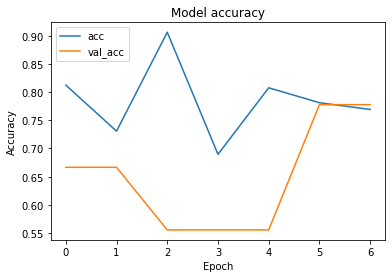

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

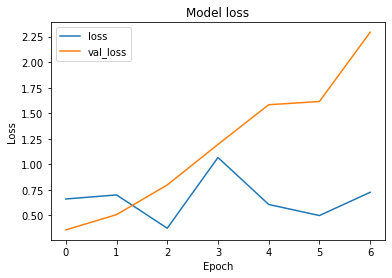

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [17]:
val_data.reset()
predictions = model.predict_generator(val_data, steps=val_data.samples/val_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)
print(y_pred)
ground_truth=val_data.classes

9/9 [==============================] - 3s 334ms/step
[1 1 0 0 0 1 0 0 1]


In [18]:
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['papule','acne']
print(classification_report(val_data.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      papule       0.80      0.80      0.80         5
        acne       0.75      0.75      0.75         4

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



In [19]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

5/5 [==============================] - 1s 112ms/step


In [20]:
print(y_pred)
ground_truth=test['label']
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['papule', 'acne']
print(classification_report(ground_truth, y_pred, target_names=target_names))

[0 0 1 1 0]
Classification Report
              precision    recall  f1-score   support

      papule       1.00      0.75      0.86         4
        acne       0.50      1.00      0.67         1

    accuracy                           0.80         5
   macro avg       0.75      0.88      0.76         5
weighted avg       0.90      0.80      0.82         5



In [21]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

5/5 [==============================] - 1s 102ms/step


In [22]:
ground_truth=test['label']
print('Confusion Matrix')
print(confusion_matrix(ground_truth, y_pred))

Confusion Matrix
[[3 1]
 [0 1]]


In [23]:
from keras.models import load_model

model.save('fine_two_class.h5')